# Problem Set 6

### Aim: Compare OLS, ridge regression, lasso and PCR

Baseline : $Y=X\beta+\varepsilon$

- $n = 100$
- $p = 2$ (Initially), later on $p = 10$ 
- $X \sim N_p(\mu, \Sigma)$
- $\mu = (0 \quad 10)$
- The true coefficients $\beta$ range from 0.1 to 0.5 
-  $\varepsilon \sim N (0, 1)$.

#### Data Generating process

In [47]:
rm(list = ls())
set.seed (11)

#install.packages("devtools")
#install.packages("MASS")
#install_github("vqv/ggbiplot")
#suppressMessages(library(MASS))
#suppressMessages(library(devtools))
#suppressMessages(library(ggbiplot))

n <-100
p <-2

#covariance matrix

offdiag <- function (x, at =0) {
  if (is.matrix(x)) {
    result <- x[row(x) == col(x) - at]
  } else {
    len <- length(x)
    result <- matrix(0.5, nrow = len + abs(at), ncol = len + abs(at))
    result[row(result) == col(result) - at] <- x
  }
  return(result)
}
cov <- offdiag (x= rep(3,p), at=0)

#true means and coefficients

true.means <- seq(from = 0, to = 10, length.out = p)
true.coefficients <- runif (p, 0.1, 0.5)
    
X <-mvrnorm(n= n, mu = true.means, Sigma = cov)

error <- rnorm(n, 0, 1)

Y <- X %*% true.coefficients + error

data <- data.frame ("y" = Y, "x.1" = X[,1], "x.2" = X[,2])


# Exercise 1

## Part a) Calculate principal component scores and visualize them along with the original observations

In [48]:
data.pca <- data.frame (X)
suppressMessages(library(pls))



#Calculate principal component scores directly
pca <- prcomp (data.pca, center = TRUE, scale = FALSE)

summary (pca)
pca.scores <-pca$x


Importance of components:
                          PC1    PC2
Standard deviation     1.7110 1.5499
Proportion of Variance 0.5493 0.4507
Cumulative Proportion  0.5493 1.0000

In [49]:
#Calculate principal component scores manually
x1 <-X[,1]
x2 <-X[,2]

#center the data
x1.centered <- x1 - mean(x1)
x2.centered <- x2 - mean(x2)

X.centered <-cbind(x1.centered, x2.centered)

#compute the covariance matrix
cov.X.centered <- cov(X.centered)

#calculate eigenvalues and eigenvectors of the covariance matrix
eigenvectors <-eigen(cov.X.centered)$vectors
eigenvalues <-eigen(cov.X.centered)$values
eigenvectors
eigenvalues


#eigenvectors with the highest eigenvalue contains the most information about the distribution of the data

0.6370615,-0.7708130
0.7708130,0.6370615


[1] 2.927417 2.402181

In [50]:
#test wether they are correctly scaled
sqrt(eigenvectors[1,1]^2 +eigenvectors[2,1]^2)      
sqrt(eigenvectors[1,2]^2 +eigenvectors[2,2]^2)

[1] 1

[1] 1

In [52]:
#calculate principal component scores
pca.scores.manually <- X.centered %*% eigenvectors

colnames(pca.scores.manually)<-c("PC1.man", "PC2.man")
head(pca.scores.manually)
head(pca.scores)

PC1.man,PC2.man
0.2932598,0.1471087
-2.5279558,0.9760122
-2.3485189,-0.1795329
2.0926579,-3.6980864
-1.4449340,0.8554046
2.7456187,0.3044474


PC1,PC2
0.2932598,-0.1471087
-2.5279558,-0.9760122
-2.3485189,0.1795329
2.0926579,3.6980864
-1.4449340,-0.8554046
2.7456187,-0.3044474


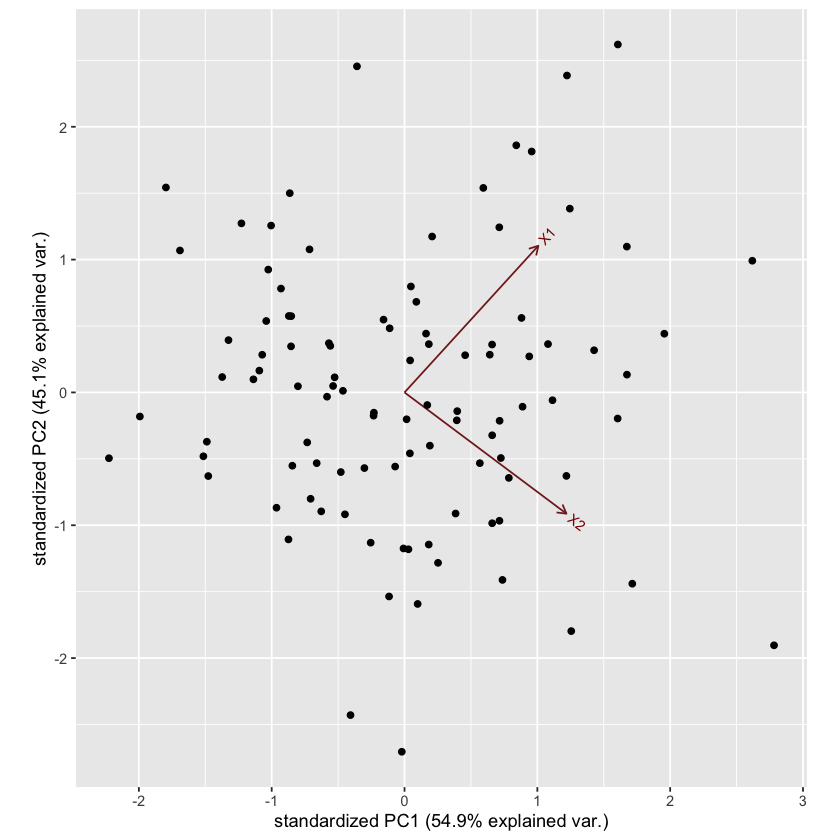

In [7]:
## Plot PC along with original data
ggbiplot(pca)



# Part b) Perform PCR using one and both pricinpal components

Data: 	X dimension: 100 1 
	Y dimension: 100 1
Fit method: svdpc
Number of components considered: 1

VALIDATION: RMSEP
Cross-validated using 10 random segments.
       (Intercept)  1 comps
CV           1.046    1.028
adjCV        1.046    1.026

TRAINING: % variance explained
   1 comps
X  100.000
Y    8.522


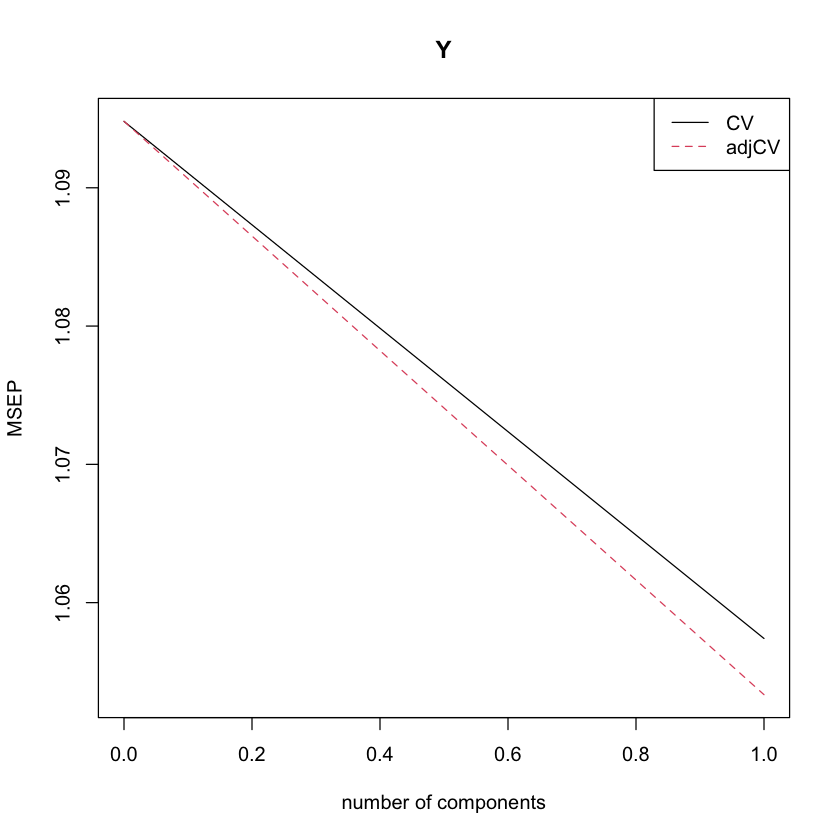

In [8]:
suppressMessages(library(pls))

pca.scores <- pca$x

#one component

data2 <-cbind(data, pca.scores)

pcr.model.1 <- pcr(Y ~ x.1, data = data2, scale = TRUE, validation = "CV")
summary (pcr.model.1)

# Validation Plot
validationplot(pcr.model.1, val.type="MSEP", legendpos = "topright")

Data: 	X dimension: 100 2 
	Y dimension: 100 1
Fit method: svdpc
Number of components considered: 2

VALIDATION: RMSEP
Cross-validated using 10 random segments.
       (Intercept)  1 comps  2 comps
CV           1.046   0.9933    1.007
adjCV        1.046   0.9921    1.005

TRAINING: % variance explained
   1 comps  2 comps
X    54.84   100.00
Y    12.11    12.37


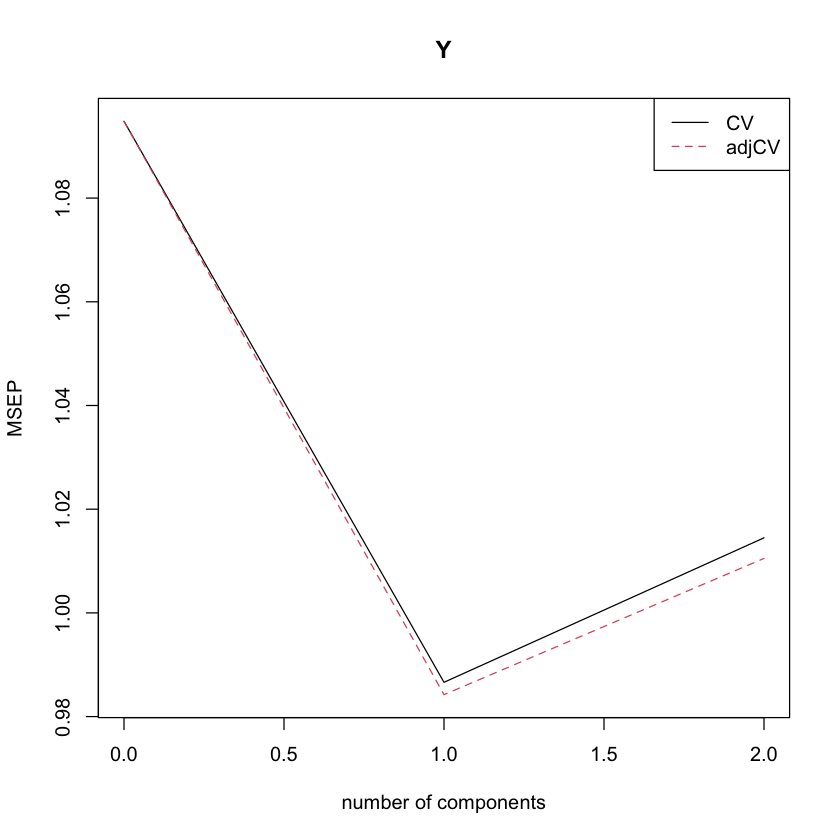

In [9]:
#two components

pcr.model.2 <- pcr (Y ~ X, data = data2, scale = TRUE, validation = "CV", ncomp = 2)
summary (pcr.model.2)

# Validation Plot
validationplot (pcr.model.2, val.type = "MSEP", legendpos = "topright")


# Part c) Prediction error for Ridge, Lasso and PCR using one and two principal components

In [115]:
set.seed(22)

#data partitioning

index <-sample(1:nrow(data2), nrow(data2)*0.8)

train.data <- data2 [index,]
test.data <- data2[-index,]

y.train <- train.data$y
y.test <- test.data$y

x.train <- data.matrix (train.data[ ,c("PC1", "PC2")]) #glmnet requires it to be a matrix
x.test <- data.matrix (test.data[ ,c("PC1", "PC2")]) #glmnet requires it to be a matrix


In [116]:
set.seed(11)
#install.packages ("glmnet")
suppressMessages(library(glmnet))



#list of lambda values for the model to try
grid <- 10^seq(2,-2,length.out=100)

#find optimal lambda for Ridge (perform k-fold cross validation)
cv.ridge <- cv.glmnet(x.train, y.train, alpha = 0, lambda = grid)
optimal.lambda.ridge <- cv.ridge$lambda.min
optimal.lambda.ridge

#find optimal lambda for Lasso (perform k-fold cross validation)
cv.lasso <- cv.glmnet(x.train, y.train, alpha = 1, lambda = grid)
optimal.lambda.lasso <- cv.lasso$lambda.min
optimal.lambda.lasso


[1] 0.3125716

[1] 0.01321941

In [117]:
#Ridge

ridge.model <- glmnet(x.train, y.train, lambda = optimal.lambda.ridge, alpha = 0)

ridge.pred <- predict (ridge.model, newx = x.test)
mse.ridge <- mean ((ridge.pred - y.test)^2)
mse.ridge


[1] 1.160116

In [118]:
#Lasso

lasso.model<- glmnet (x.train, y.train, lambda = optimal.lambda.lasso, alpha =1)

lasso.pred <- predict (lasso.model, newx = x.test)
mse.lasso <- mean ((lasso.pred - y.test)^2)
mse.lasso


[1] 1.110405

In [119]:
#PCR with one principal component

pcr.model.1 <- pcr (Y ~ X, data = train.data, scale = TRUE, validation = "CV", ncomp = 1)

pcr.pred.1 <- predict (pcr.model.1, ncomp = 1, newx = x.test)
mse.pcr.1 <- mean ((pcr.pred.1 - y.test )^2)
mse.pcr.1

[1] 1.632816

In [120]:
#PCR with two principal components

pcr.model.2 <- pcr(Y~X, data = train.data, scale = TRUE, validation = "CV", ncomp = 2)

pcr.pred.2 <- predict (pcr.model.2, ncomp = 2, newx = x.test)
mse.pcr.2 <- mean ((pcr.pred.2 - y.test)^2)
mse.pcr.2


[1] 1.62961

In [124]:
# All MSE values in a table
all.mse <- cbind(mse.ridge, mse.lasso, mse.pcr.1, mse.pcr.2)
colnames(all.mse) <- c("Ridge", "Lasso", "PCR with one component", "PCR with two components")

all.mse

Ridge,Lasso,PCR with one component,PCR with two components
1.160116,1.110405,1.632816,1.62961


# Exercise 2

# a) Difference in prediction performance : OLS, Ridge, Lasso & PCR

In [187]:
rm(list = ls())
# Load packages
suppressMessages(library(MASS))
suppressMessages(library(pls))
suppressMessages(library(psych))
suppressMessages(library(glmnet))


In [188]:
n.<-100
set.seed(22)

p<-10

In [189]:
## Cov matrix function
offdiag <- function (x, at =0) {
  if (is.matrix(x)) {
    result <- x[row(x) == col(x) - at]
  } else {
    len <- length(x)
    result <- matrix(0, nrow = len + abs(at), ncol = len + abs(at))
    result[row(result) == col(result) - at] <- x
  }
  return(result)
}

In [190]:
# Set values 
true.means <- seq(from = 0, to =10, length.out = p)
true.coefficients = runif(p,0.1,0.5)
cov<-offdiag(x= rep(1,p), at=0)

X<-mvrnorm(n=n.,mu=true.means,Sigma=cov)
error<- rnorm(n=n.,mean=0, sd=1)
Y<- X %*% true.coefficients + error

# Number of repetitions
rep<-50

MSE.sim <- matrix(NA,rep,4)
colnames(MSE.sim) <- c("OLS", "Ridge", "Lasso", "PCR")

# Set grid
grid<-10^seq(2,-2,length.out=100)

### Run OLS, Ridge, Lasso and PCR within a loop

In [192]:
for (i in 1:rep){
  
  ## training sample
  cov.sim<-offdiag(x= rep(1,p), at=0)
  X.sim<- mvrnorm(n=n., mu=true.means, Sigma=cov.sim)
  errors<- rnorm(n=n.,1)
  Y.sim <- X.sim %*% true.coefficients + errors
  data.sim <- data.frame ("Y.sim"=Y.sim, "X.sim"=X.sim)
  
  ##test sample
  X.sim.test<-mvrnorm(n=n., mu=true.means, Sigma=cov.sim)
  errors.test<-rnorm(n=n.,1)
  Y.sim.test<-X.sim.test %*% true.coefficients+ errors.test
  data.sim.test <- data.frame ("Y.sim.test"=Y.sim.test, "X.sim.test"=X.sim.test)
  
  ## Implement the 4 methods
    
  # OLS Regression
  
  # lm.fit <- lm(Y.sim ~X.sim -1)
  #lm.fit.predict <- X.sim.test %*% lm.fit$coefficient
  
  lm.fit<-glmnet(X.sim, Y.sim, alpha = 0, lambda = 0,family="gaussian")
  lm.fit.predict<-predict(lm.fit,newx=X.sim.test)
  
  #OLS MSE 
  MSE.sim[i,1] <- mean((lm.fit.predict-Y.sim.test)^2)
  
  ## Ridge Regression
  
  ridge.sim <- glmnet(X.sim, Y.sim, alpha = 0, family = 'gaussian', lambda = grid, intercept = FALSE)
  
  cv_ridge.sim <- cv.glmnet(X.sim, Y.sim, alpha = 0, lambda = grid)
  optimal_lambda <- cv_ridge.sim$lambda.min
  
  ridge.predict <- predict(ridge.sim, s= optimal_lambda, newx = X.sim.test)
  
  # Ridge MSE
  MSE.sim[i,2] <- mean(( ridge.predict - Y.sim.test)^2)
  
  
  ########## LASSO Regression
  lasso.sim = glmnet(X.sim, Y.sim, alpha = 1, family = 'gaussian', lambda = grid, intercept = FALSE, standardize = TRUE)
  cv_lasso.sim <- cv.glmnet(X.sim, Y.sim, alpha = 1, lambda = grid)
  optimal_lambda.lasso <- cv_lasso.sim$lambda.min
  lasso.predict <- predict(lasso.sim, s= optimal_lambda.lasso, newx = X.sim.test)
    
  # LASSO MSE
  MSE.sim[i,3] <- mean(( lasso.predict - Y.sim.test)^2)
    
  
  ###### PCR Regression
  pcr.reg.sim <- pcr(Y.sim ~X.sim, data=data.sim, scale= TRUE, validation="CV")
   pca <- prcomp(data.sim[,-1], center = TRUE, scale = TRUE)
  
  predictions_train_pcr <- predict(pcr.reg.sim, data.sim.test, ncomp = 9)
  
  
  # MSE PCR
  MSE.sim[i,4] <- mean((Y.sim.test-predictions_train_pcr[,,1])^2)
  
}

# Compute row means for the 4 Methods
  colMeans(MSE.sim)



OLS    Ridge    Lasso      PCR 
1.121011 1.105381 1.113253 3.453170

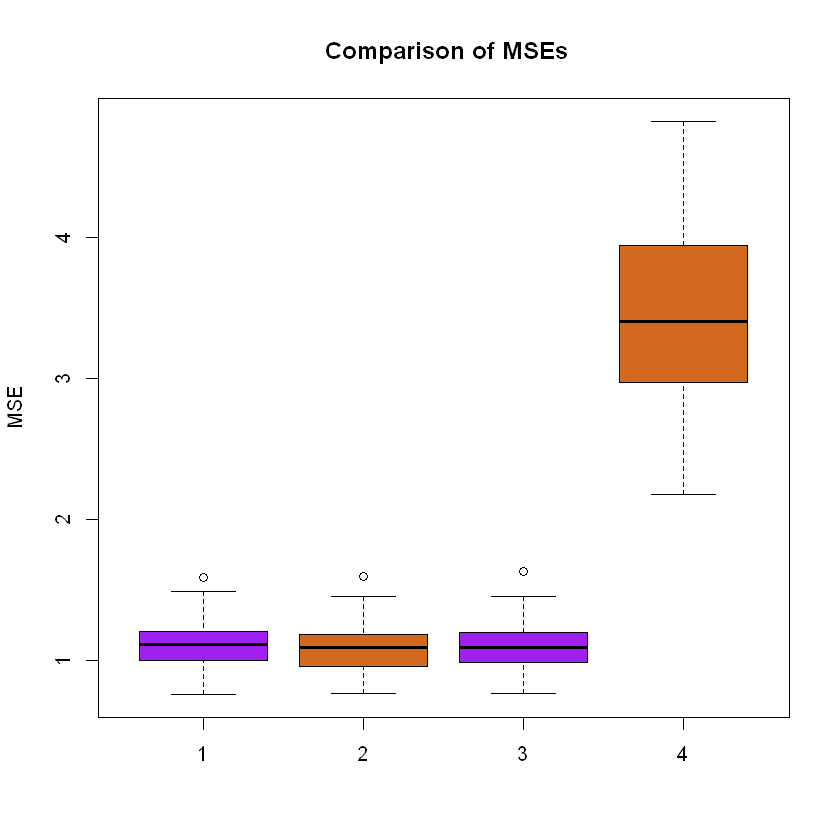

In [193]:
## Box Plots of Means

boxplot(cbind(MSE.sim[,1],MSE.sim[,2],MSE.sim[,3],MSE.sim[,4]),  ylab = "MSE", col = c("purple", "chocolate"), main = " Comparison of MSEs" )
  lines(0:7,rep(10,8),col="blue", lwd= 1.5)


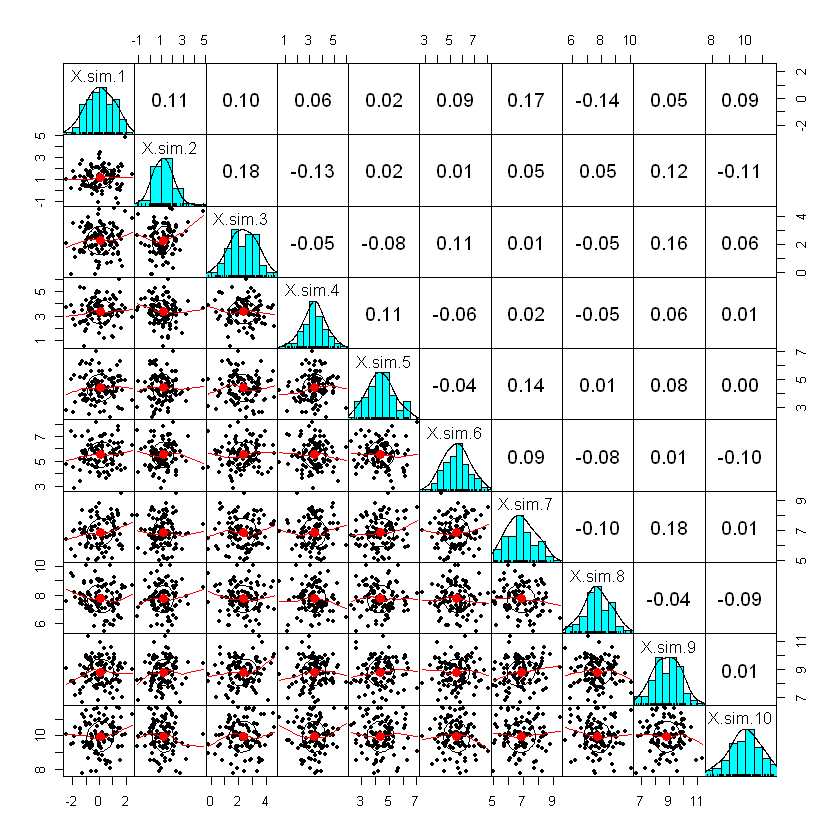

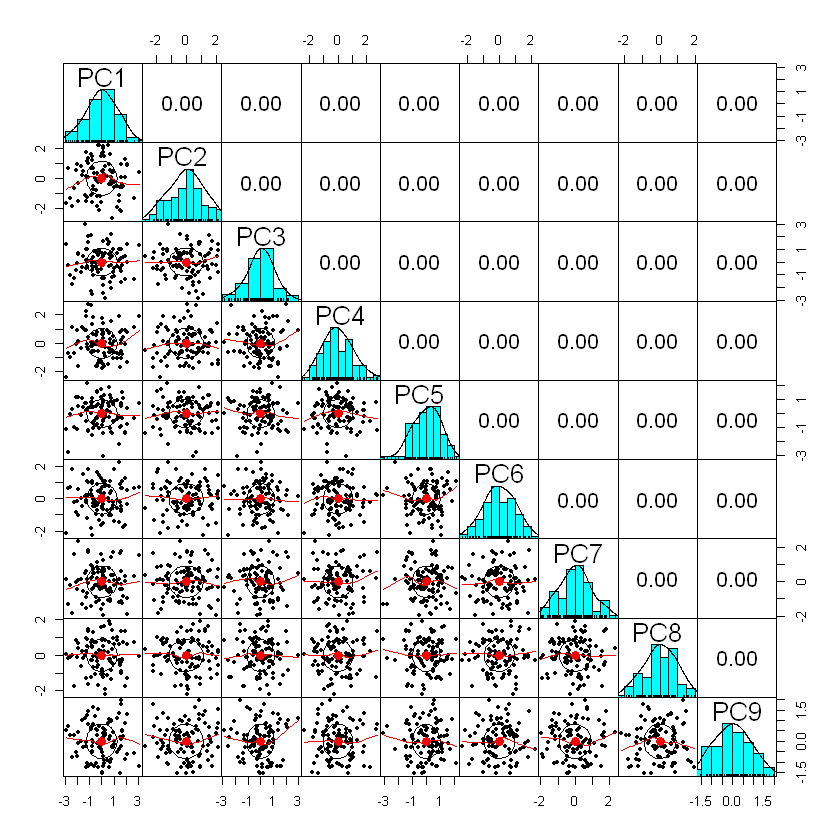

In [194]:
## Extra Task : Check Correlations X variables correlations before and after PCA

# Before PCA
pairs.panels(data.sim[,-1],
               gap=0,
               bg = c("red", "yellow", "blue"),
               pch=20)

# After PCA
pairs.panels(pca$x[,-10],
             gap=0,
             bg = c("red", "yellow", "blue"),
             pch=20)

# b) Manipulation of DGP

#### $\textbf{Manipulation 1 : Increase $\lambda$ }$ 

Recall from Lasso Regression that : When $\lambda=0$, no parameters are eliminated. As $\lambda$ increases, more and more coefficients are set to zero and eliminated (theoretically, when $\lambda = \infty$, all coefficients are eliminated). As $\lambda$ increases, bias increases. Still, as $\lambda$ decreases, variance increases.

In [195]:
# Set a new Grid with higher values
grid<-10^seq(2,3,length.out=100)

head(grid)

[1] 100.0000 102.3531 104.7616 107.2267 109.7499 112.3324

In [196]:
## Same story

for (i in 1:rep){
  
  ## training sample
  cov.sim<-offdiag(x= rep(1,p), at=0)
  X.sim<- mvrnorm(n=n., mu=true.means, Sigma=cov.sim)
  errors<- rnorm(n=n.,1)
  Y.sim <- X.sim %*% true.coefficients + errors
  data.sim <- data.frame ("Y.sim"=Y.sim, "X.sim"=X.sim)
  
  ## test sample
  X.sim.test<-mvrnorm(n=n., mu=true.means, Sigma=cov.sim)
  errors.test<-rnorm(n=n.,1)
  Y.sim.test<-X.sim.test %*% true.coefficients+ errors.test
  data.sim.test <- data.frame ("Y.sim.test"=Y.sim.test, "X.sim.test"=X.sim.test)
  
  ########## OLS Regression
  
  # lm.fit <- lm(Y.sim ~X.sim -1)
  #lm.fit.predict <- X.sim.test %*% lm.fit$coefficient
  
  lm.fit<-glmnet(X.sim, Y.sim, alpha = 0, lambda = 0,family="gaussian")
  lm.fit.predict<-predict(lm.fit,newx=X.sim.test)
  
    ## Implement the 4 methods

  # OLS MSE 
  MSE.sim[i,1] <- mean((lm.fit.predict-Y.sim.test)^2)
  #
  
  ########## Ridge Regression
  ridge.sim <- glmnet(X.sim, Y.sim, alpha = 0, family = 'gaussian', lambda = grid, intercept = FALSE)
  
  cv_ridge.sim <- cv.glmnet(X.sim, Y.sim, alpha = 0, lambda = grid)
  optimal_lambda <- cv_ridge.sim$lambda.min
  
  ridge.predict <- predict(ridge.sim, s= optimal_lambda, newx = X.sim.test)
  
  # Ridge MSE
  MSE.sim[i,2] <- mean(( ridge.predict - Y.sim.test)^2)
  
  ########## LASSO Regression
  lasso.sim = glmnet(X.sim, Y.sim, alpha = 1, family = 'gaussian', lambda = grid, intercept = FALSE, standardize = TRUE)
  cv_lasso.sim <- cv.glmnet(X.sim, Y.sim, alpha = 1, lambda = grid)
  optimal_lambda.lasso <- cv_lasso.sim$lambda.min
  lasso.predict <- predict(lasso.sim, s= optimal_lambda.lasso, newx = X.sim.test)
  # LASSO MSE
  MSE.sim[i,3] <- mean(( lasso.predict - Y.sim.test)^2)
  
  
  ########## PCR Regression
  pcr.reg.sim <- pcr(Y.sim ~X.sim, data=data.sim, scale= TRUE, validation="CV")
  pca <- prcomp(data.sim[,-1], center = TRUE, scale = TRUE)
  
  predictions_train_pcr <- predict(pcr.reg.sim, data.sim.test, ncomp = 9)
  
  
  # MSE PCR
  MSE.sim[i,4] <- mean((Y.sim.test-predictions_train_pcr[,,1])^2)
  
 }
# Compute row means for the 4 Methods
  colMeans(MSE.sim)

## Box Plots 

# boxplot(cbind(MSE.sim[,1],MSE.sim[,2],MSE.sim[,3],MSE.sim[,4]),  ylab = "MSE", col = c("purple", "chocolate"), main = " Comparison of MSEs" )
# lines(0:7,rep(10,8),col="blue", lwd= 1.5)


OLS      Ridge      Lasso        PCR 
  1.105106   1.435324 320.310177   3.394622

#### $\textbf{Manipulation 2 : Increase off-diagonal covariance from 0 to 0.9 }$ 

In [199]:
## Set new Beta values
true.coefficients <- runif(p,.01,.05)

## Cov matrix function
offdiag <- function (x, at =0) {
  if (is.matrix(x)) {
    result <- x[row(x) == col(x) - at]
  } else {
    len <- length(x)
    result <- matrix(0.7, nrow = len + abs(at), ncol = len + abs(at))
    result[row(result) == col(result) - at] <- x
  }
  return(result)
}


In [201]:
rep<-50

for (i in 1:rep){
  
  ## training sample
  cov.sim<-offdiag(x= rep(1,p), at=0)
  X.sim<- mvrnorm(n=n., mu=true.means, Sigma=cov.sim)
  errors<- rnorm(n=n.,1)
  Y.sim <- X.sim %*% true.coefficients + errors
  data.sim <- data.frame ("Y.sim"=Y.sim, "X.sim"=X.sim)
  
  ## test sample
  X.sim.test<-mvrnorm(n=n., mu=true.means, Sigma=cov.sim)
  errors.test<-rnorm(n=n.,1)
  Y.sim.test<-X.sim.test %*% true.coefficients+ errors.test
  data.sim.test <- data.frame ("Y.sim.test"=Y.sim.test, "X.sim.test"=X.sim.test)
    
      ## Implement the 4 methods
  
  ########## OLS 
  
  # lm.fit <- lm(Y.sim ~X.sim -1)
  #lm.fit.predict <- X.sim.test %*% lm.fit$coefficient
  
  lm.fit<-glmnet(X.sim, Y.sim, alpha = 0, lambda = 0,family="gaussian")
  lm.fit.predict<-predict(lm.fit,newx=X.sim.test)
  
  
  # OLS MSE 
  MSE.sim[i,1] <- mean((lm.fit.predict-Y.sim.test)^2)
  #
  
  ########## Ridge
  ridge.sim <- glmnet(X.sim, Y.sim, alpha = 0, family = 'gaussian', lambda = grid, intercept = FALSE)
  
  cv_ridge.sim <- cv.glmnet(X.sim, Y.sim, alpha = 0, lambda = grid)
  optimal_lambda <- cv_ridge.sim$lambda.min
  
  ridge.predict <- predict(ridge.sim, s= optimal_lambda, newx = X.sim.test)
  
  # Ridge MSE
  MSE.sim[i,2] <- mean(( ridge.predict - Y.sim.test)^2)
  
  ########## LASSO
  lasso.sim = glmnet(X.sim, Y.sim, alpha = 1, family = 'gaussian', lambda = grid, intercept = FALSE, standardize = TRUE)
  cv_lasso.sim <- cv.glmnet(X.sim, Y.sim, alpha = 1, lambda = grid)
  optimal_lambda.lasso <- cv_lasso.sim$lambda.min
  lasso.predict <- predict(lasso.sim, s= optimal_lambda.lasso, newx = X.sim.test)
  # LASSO MSE
  MSE.sim[i,3] <- mean(( lasso.predict - Y.sim.test)^2)
  
  
  ########## PCR
  pcr.reg.sim <- pcr(Y.sim ~X.sim, data=data.sim, scale= TRUE, validation="CV")
  pca <- prcomp(data.sim[,-1], center = TRUE, scale = TRUE)
  
  predictions_train_pcr <- predict(pcr.reg.sim, data.sim.test, ncomp = 9)
  
  
  # MSE PCR
  MSE.sim[i,4] <- mean((Y.sim.test-predictions_train_pcr[,,1])^2)
  
}
# Compute row means for the 4 Methods
  colMeans(MSE.sim)

#  boxplot(cbind(MSE.sim[,1],MSE.sim[,2],MSE.sim[,3],MSE.sim[,4]),  ylab = "MSE", col = c("purple", "chocolate"), main = " Comparison of MSEs" )
#  lines(0:7,rep(10,8),col="blue", lwd= 1.5)



OLS    Ridge    Lasso      PCR 
1.111503 1.199546 6.307687 1.249622